# Introduction to Convolutional Neural Networks ans Computer Vision with TensorFlow

Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such as a camera of self-driving car recognizng the car in front.

In [1]:
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

## Get Data
The images we-re working with are from the Food101 dataset (101 different classes of food): https://www.kaggle.com/dansbecker/food-101

However we've modified it to only use two classes (pizza & steak) using the image data modification notebook: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

**Note:** We start with a smaller dataset so we can experiment quickly and figure what works (or better yet what doesn't work) before scaling up.

In [3]:
import requests

import zipfile

import io



# Download the zip file using requests

url = "https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip"

response = requests.get(url)



# Unzip the file in memory and extract it

with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:

    zip_ref.extractall("pizza_steak")  # Extract to a folder called 'pizza_steak'

## Inspect the data (become one with it)

A very crucial step at beginning of any machine learning project is becoming one with the data.

And for a computer vision project... this usually means visualizing many samples of your data.

In [2]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk('../data/pizza_steak'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in ../data/pizza_steak
There are 2 directories and 0 images in ../data/pizza_steak\test
There are 0 directories and 250 images in ../data/pizza_steak\test\pizza
There are 0 directories and 250 images in ../data/pizza_steak\test\steak
There are 2 directories and 0 images in ../data/pizza_steak\train
There are 0 directories and 750 images in ../data/pizza_steak\train\pizza
There are 0 directories and 750 images in ../data/pizza_steak\train\steak


In [3]:
# Anather way to find out how many images are in a file
num_steak_images_train = len(os.listdir("../data/pizza_steak/train/steak"))

num_steak_images_train

750

To visualize our images, first let's get the class names programmatically

In [4]:
# Get the classnames programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path("../data/pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


In [14]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    # Setup the targeet dirctory (we'll view images from here)
    target_folder = target_dir + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape: {img.shape}") # show the shape of the image

    return img

Image shape: (512, 512, 3)


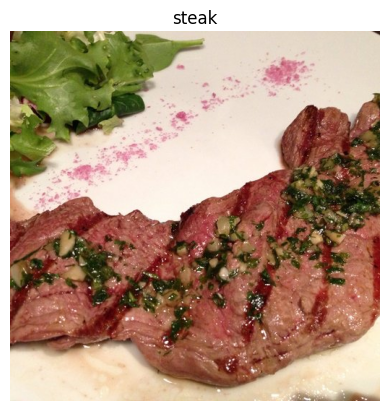

In [6]:
# View the training image from the training dataset
img = view_random_image(target_dir="../data/pizza_steak/train/",
                        target_class="steak")

In [7]:
tf.constant(img)

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 74,  31,  25],
        [ 72,  32,  22],
        [ 62,  26,  10],
        ...,
        [ 48,  27,  22],
        [ 50,  29,  24],
        [ 52,  31,  26]],

       [[ 67,  24,  18],
        [ 66,  26,  16],
        [ 61,  25,   9],
        ...,
        [ 52,  31,  26],
        [ 49,  28,  23],
        [ 45,  24,  19]],

       [[ 61,  20,  14],
        [ 60,  22,  11],
        [ 59,  26,   9],
        ...,
        [ 39,  20,  13],
        [ 46,  27,  20],
        [ 54,  35,  28]],

       ...,

       [[247, 242, 223],
        [247, 242, 223],
        [246, 241, 222],
        ...,
        [170, 141, 111],
        [174, 145, 115],
        [177, 148, 118]],

       [[243, 240, 221],
        [243, 240, 221],
        [244, 239, 220],
        ...,
        [159, 129, 101],
        [162, 132, 104],
        [164, 134, 106]],

       [[240, 237, 218],
        [240, 237, 218],
        [241, 236, 217],
        ...,
        [151, 121,  9

In [8]:
# View the image shape
img.shape # returns width, height, colour channels

(512, 512, 3)

> **Note:** As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also reffered to as **normilize**) their pixel values by dividing the image arrays by 255. (since 255 is the maximum pixel value). 

## An end-to-end example

Let's build a convolutional neural network to find patterns in our images, more specifically we are need way to:
* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data

> Outdated version

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup path to our directory
train_dir = '../data/pizza_steak/train'
test_dir = '../data/pizza_steak/test'

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

print(valid_data.samples)

# Build a CNN model (same as the Tiny VGG on the CNN explainer webside)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),  # Явное указание входной формы
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, padding='valid'),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile our CNN
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                       epochs=5,
                       validation_data=valid_data,
                       validation_steps=None
                       )

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
500
Epoch 1/5


C:\Users\79279\Documents\IT\data_sciense\daniel_bourke_course\datascience\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 249ms/step - accuracy: 0.6650 - loss: 0.5878 - val_accuracy: 0.8280 - val_loss: 0.4296
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.7909 - loss: 0.4683 - val_accuracy: 0.7700 - val_loss: 0.4693
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 0.7936 - loss: 0.4609 - val_accuracy: 0.8280 - val_loss: 0.3967
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.8179 - loss: 0.4100 - val_accuracy: 0.8780 - val_loss: 0.3391
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - accuracy: 0.8445 - loss: 0.3630 - val_accuracy: 0.8620 - val_loss: 0.3338


> Updated version

In [7]:
# Import tools
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory as Images

# Set seed
tf.random.set_seed(1)

# Set directory
images_dir_train = "../data/pizza_steak/train"
images_dir_test = "../data/pizza_steak/test"

# Load images and split them into batches (NO NEED TO DEFINE HOW MANY CLASSES HERE, SINCE IT WILL BE INFERRED FROM DIRECTORY STRUCTURE AUTOMATICALLY)
# Load images and split them into batches
train_data = Images(
    images_dir_train,
    image_size = (224, 224),
    batch_size = 32
)

test_data = Images(
    images_dir_test,
    image_size = (224, 224),
    batch_size = 32
)

# Set number of classes
num_classes = len(train_data.class_names)

# Build model, indicating Rescaling layer as a first layer
model_1 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

# Compile model
model_1.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

# Train model
history_1 = model_1.fit(
  train_data,
  validation_data=test_data,
  epochs=5
)

Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step - accuracy: 0.5939 - loss: 0.9061 - val_accuracy: 0.7560 - val_loss: 0.4995
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 276ms/step - accuracy: 0.7895 - loss: 0.4653 - val_accuracy: 0.8420 - val_loss: 0.3882
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 252ms/step - accuracy: 0.8349 - loss: 0.3967 - val_accuracy: 0.8500 - val_loss: 0.3161
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 241ms/step - accuracy: 0.8614 - loss: 0.3363 - val_accuracy: 0.8700 - val_loss: 0.2877
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 239ms/step - accuracy: 0.9040 - loss: 0.2494 - val_accuracy: 0.8780 - val_loss: 0.2969


In [8]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,769,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,366,024 (31.91 MB)

 Trainable params: 2,788,674 (10.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,577,350 (21.28 MB)

## Using the same model as before

Let's replicate the model we've build in a previous section to see if it works with our image data.

The model we're building is from Tensorflow playground

In [9]:
# Set random 
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        validation_data=test_data,
                       )

Epoch 1/5


C:\Users\79279\Documents\IT\data_sciense\daniel_bourke_course\datascience\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4802 - loss: 25.9955 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5167 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4903 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5085 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5090 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931


In [10]:
# Get a summary of model_2
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │         602,116 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,806,425 (6.89 MB)

 Trainable params: 602,141 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,204,284 (4.59 MB)

> Despite having 20x more parameters than our CNN (model_1), model_2 performs terrible. Let's try to improve it.

In [11]:
# Set the random seed
tf.random.set_seed(42)

# Create the model (same as model_2)
model_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        validation_data=test_data)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.5670 - loss: 2853.1746 - val_accuracy: 0.6000 - val_loss: 413.6845
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.6882 - loss: 345.0073 - val_accuracy: 0.7960 - val_loss: 124.3890
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7532 - loss: 138.8020 - val_accuracy: 0.7600 - val_loss: 75.1810
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.7059 - loss: 222.6112 - val_accuracy: 0.7480 - val_loss: 190.2239
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.7478 - loss: 141.1747 - val_accuracy: 0.7620 - val_loss: 46.6295


In [12]:
# Get the model_3 summary
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │      15,052,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,189,305 (172.38 MB)

 Trainable params: 15,063,101 (57.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,126,204 (114.92 MB)

> **Note:** You can think of trainable parameters as **patterns a model can learn from data**, Intuitively, you might think more is better. And in lots of cases, it is. But in this case, the difference here is two different styles of model we're using. Where a series of dense layers has a number of different learnable parameters connected to each other and hence a higher number of possible learnable patterns, **a CNN seeks to sort out and learn the most important patterns in an image**. So even though these are less learnable parameters in our CNN, these are often more helphul in dechiphering between different **features** in an image.

## Binary Classification: Let's break it down

1. Become one with data (visualize, visualize, visualize)
2. Preprocess the data (prepared it for our model, the main step here was scalling/normalizing)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve the model (try to beat our baseline)
7. Repeat until satisfied (experiment, experiment, experiment)

### 1. Become one with the data

Image shape: (512, 512, 3)
Image shape: (384, 512, 3)


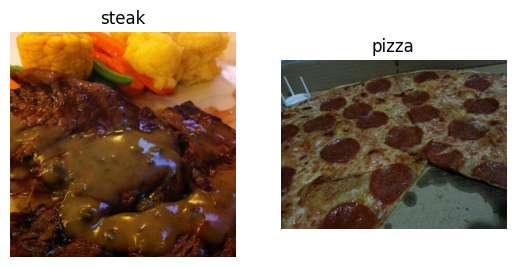

In [16]:
import os

# Visualize data
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("../data/pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("../data/pizza_steak/test/", "pizza")
plt.show();

### 2. Preprocess the data (prepare it for a model)

In [17]:
# Define directory dataset paths
train_dir = "../data/pizza_steak/train/"
test_dir = "../data/pizza_steak/test/"

> Our next step is turn our data into **batches**
> 
> A batch is a small subset of data. Rather than look at all over 10 000 images at one time, a model might only look at 32 at time.
>
> It does this for a couple of reasons:
> 1. 10 000 images (or more) might not fit into the memory of your processor (GPU)
> 2. Trying to learn the patterns in 10 000 images in one hit could result in the model not being able to learn very well.
>
> Why 32?
>
> Becouse 32 is good for your helth.


In [75]:
# Create train and test data generators and rescale the data
 
# Create our train and test dataset:
from tensorflow.keras.preprocessing import image_dataset_from_directory
 
train_data = image_dataset_from_directory(directory=train_dir,
                                          label_mode="binary",
                                          batch_size=32,
                                          image_size=(224, 224),
                                          seed=42)
 
test_data = image_dataset_from_directory(directory=test_dir,
                                         label_mode="binary",
                                         batch_size=32,
                                         image_size=(224, 224),
                                         seed=42)

Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [19]:
# How many batches are there
len(train_data)

47

In [20]:
train_data.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))

In [21]:
# Images and labels in train_data
for image, label in train_data.take(1):
    print('Image: ', image)
    print(' ')
    print('Label: ', label)

Image:  tf.Tensor(
[[[[1.07108734e+02 5.56578445e+01 1.64748096e+01]
   [1.08562500e+02 5.71116104e+01 1.79285717e+01]
   [1.03031250e+02 5.33973236e+01 1.66428566e+01]
   ...
   [5.55169392e+00 5.11604977e+00 2.37333035e+00]
   [1.86926973e+00 1.71238685e+00 0.00000000e+00]
   [1.16994262e+00 3.28760195e+00 0.00000000e+00]]

  [[1.05647003e+02 5.71961098e+01 1.71961098e+01]
   [1.06379463e+02 5.79285736e+01 1.79285717e+01]
   [1.01547516e+02 5.51948357e+01 1.68389664e+01]
   ...
   [3.19642830e+00 2.29303837e+00 1.19482422e+00]
   [5.79743087e-01 2.32504323e-01 0.00000000e+00]
   [8.69531989e-01 3.90461206e+00 1.09821415e+00]]

  [[1.02938454e+02 5.88606491e+01 1.73571434e+01]
   [1.04098213e+02 6.05433655e+01 1.87783813e+01]
   [1.02111290e+02 5.80264664e+01 1.90264683e+01]
   ...
   [4.08482122e+00 3.39284897e-01 1.69642448e-01]
   [3.39918756e+00 3.40524745e+00 3.52995133e+00]
   [0.00000000e+00 2.83434606e+00 6.05306244e+00]]

  ...

  [[6.00000000e+00 1.83032227e+00 9.15161133e-0

### 3. Create a CNN model (start with baseline)

A baseline is a relatively simple model or existing result that you setup when begining a machine learning experiment and then as you keep experimenting, you try to beat the baseline.

> **Note:** In deep learning, there is almost an infinite amount of architectures you could create. So one of the best ways to get started is to start with something simple and see if it works on your data and then introduce complexity as required (e.g. look at which current model is performing best in the field for your problem)

In [47]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Input, Rescaling, Activation, GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras import layers

In [23]:
# Create the model (this will be our baseline, a layer convolutional neural network)
model_4 = Sequential([
    Input(shape=(224, 224, 3)),
    Rescaling(scale=1/255.),
    Conv2D(filters=10, # filters is the number of sliding windows going across an input (higher = more complex model)
           kernel_size=3, # the size of the sliding window going across an input 
           strides=1, # the size of the step the sliding window takes across an input
           padding="valid", # if 'same' output shape is same as input shape, if 'valid' output shape gets compressed
           activation="relu"),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid') # Output layer
])

In [24]:
# Compile the model
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [25]:
#  Get a summary of our model
model_4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 220, 220, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 218, 218, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 475240)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │         475,241 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 477,341 (1.82 MB)

 Trainable params: 477,341 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

### 4. Fit the model

In [26]:
# Check the length of training and test data generators
len(train_data), len(test_data)

(47, 16)

In [27]:
# Fit the model
history_4 = model_4.fit(train_data, # this is a combination of labels and sample data
                        epochs=5,
                        validation_data=test_data)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.6266 - loss: 1.1818 - val_accuracy: 0.7900 - val_loss: 0.4387
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.8110 - loss: 0.4160 - val_accuracy: 0.7740 - val_loss: 0.4638
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.8699 - loss: 0.3321 - val_accuracy: 0.8340 - val_loss: 0.3901
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.9380 - loss: 0.2082 - val_accuracy: 0.8220 - val_loss: 0.4075
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 346ms/step - accuracy: 0.9765 - loss: 0.0928 - val_accuracy: 0.7980 - val_loss: 0.4966


In [28]:
model_1.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8764 - loss: 0.2960 


[0.29694923758506775, 0.878000020980835]

In [29]:
model_4.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.8009 - loss: 0.4821 


[0.4965918958187103, 0.7979999780654907]

### 5. Evaluate the model

It looks like our model is learning something, let's evaluate it.

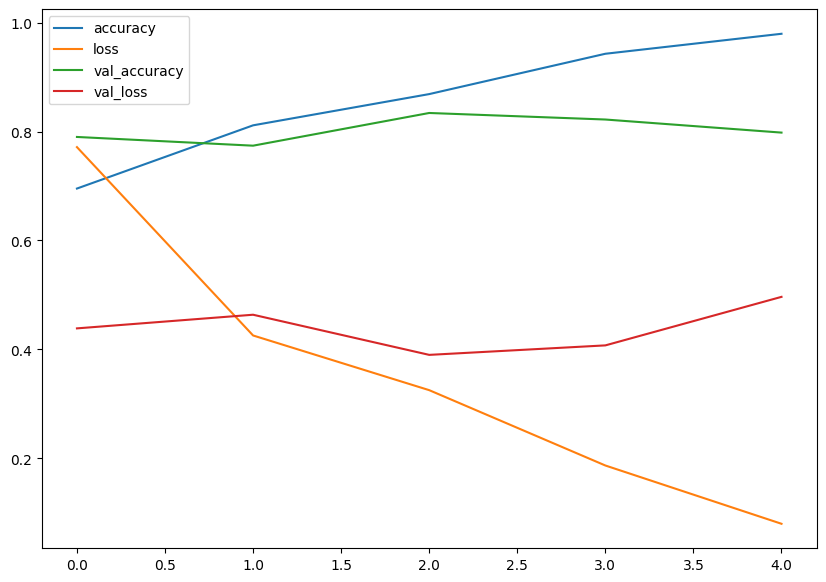

In [30]:
# Let's plot a training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7));

In [31]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training ans validation metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history["loss"])) # how many epochs did we run for?

    # Plot loss
    plt.figure()
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend();

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend();

> **Note:** When a model's **validation loss starts to increase**, it's a likely that the model is **overfitting** the training dataset. This means, it's learning the patterns in the training dataset too *well* and thus the model's ability to generalize to unseen data will be deminished.

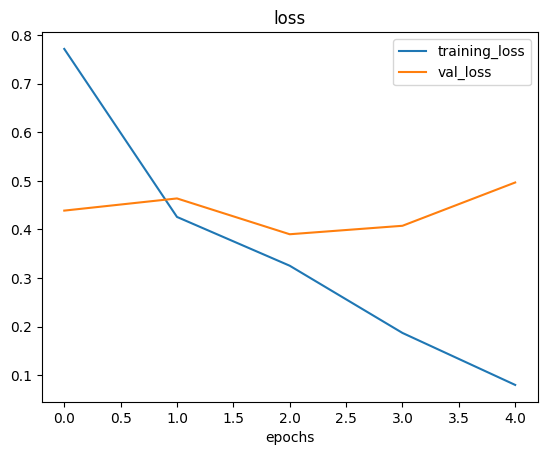

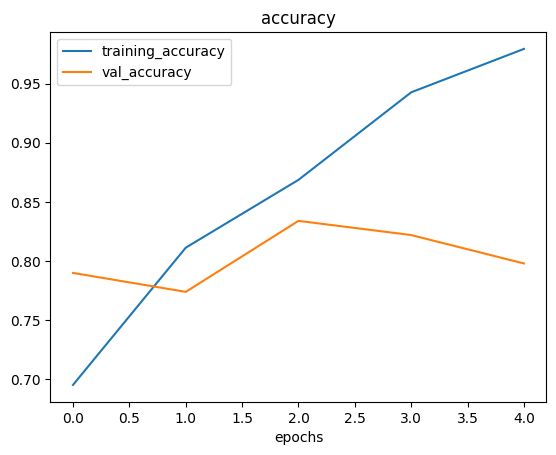

In [32]:
# Check out the loss and accuracy of model_4
plot_loss_curves(history_4)

> **Note:** Ideally the two loss curves (training and validation) will be very similar to each other (training loss and validation loss decreasing at similar rates), when there are large differences your model may be **overfitting**.

### 6. Adjust the model parameters

Fitting a machine learning model comes in 3 steps:

0. Create a baseline
1. Beat the baseline by overfitting a larger model
2. Reduce overfitting

Ways to induce overfitting:
* Increase the number of conv layers
* Increase the number of conv filters
* Add another dense layer to the output of our flattened layer

Reduce overfitting:
* Add data augmentation
* Add regularization layers (such as MaxPool2D)
* Add more data...

> **Note:** Reducing overfitting is also known as **regularization**

In [33]:
# Create the model (this is going to be our new baseline)
model_5 = Sequential([
    Input(shape=(224, 224, 3)),
    Rescaling(scale=1/255.),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [34]:
# Compile the model
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

In [35]:
# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        validation_data=test_data)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.6157 - loss: 0.6516 - val_accuracy: 0.7760 - val_loss: 0.4823
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.7728 - loss: 0.4918 - val_accuracy: 0.7920 - val_loss: 0.4553
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.8161 - loss: 0.4374 - val_accuracy: 0.8340 - val_loss: 0.4177
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.8318 - loss: 0.4284 - val_accuracy: 0.8440 - val_loss: 0.3823
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.8451 - loss: 0.3878 - val_accuracy: 0.8340 - val_loss: 0.3777


In [36]:
# Get a summary of our model with max pooling
model_5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 10)          │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 6760)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │           6,761 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,585 (103.85 KB)

 Trainable params: 8,861 (34.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,724 (69.24 KB)

In [37]:
model_4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 220, 220, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 218, 218, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 475240)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │         475,241 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,432,025 (5.46 MB)

 Trainable params: 477,341 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 954,684 (3.64 MB)

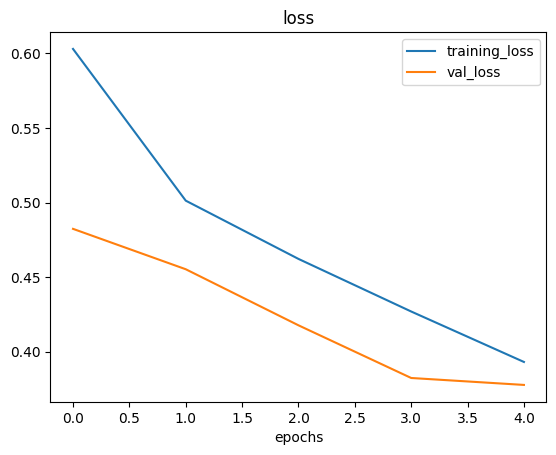

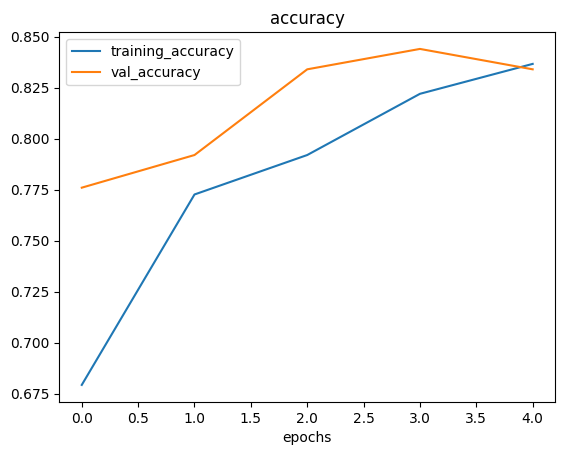

In [38]:
# Plot loss curves
plot_loss_curves(history_5)

### Opening our bag of tricks and finding data augmentation

> **Question:** What is data augmentation?

Data augmentation is the process of altering our training data, leading it to have more diversity and in turn allowing our models to learns more generalizable (hopefully) patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar

In [76]:
# Создаем слой аугментации
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),  # Случайное отражение по горизонтали
    layers.RandomRotation(0.2),       # Поворот на ±20%
    layers.RandomZoom(0.2),           # Случайное увеличение/уменьшение
    layers.RandomContrast(0.1),       # Изменение контраста
    layers.RandomWidth(0.2),          # Случайное изменение ширины
    layers.RandomHeight(0.3),         # Случайное изменение высоты
], name="data_augmentation")

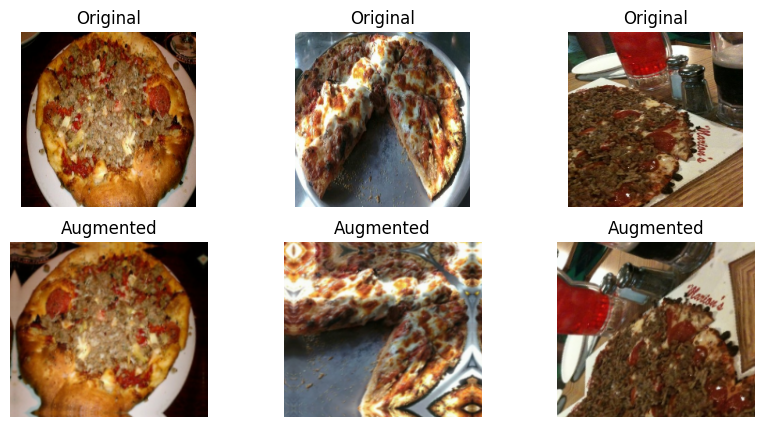

In [77]:
for images, _ in train_data.take(1):
    # Применить аугментацию
    augmented_images = data_augmentation(images)
    
    # Отобразить исходные и аугментированные изображения
    plt.figure(figsize=(10, 5))
    for i in range(3):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Original")
        plt.axis("off")
        
        plt.subplot(2, 3, i + 4)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title("Augmented")
        plt.axis("off")
    plt.show()

In [78]:
# Модель с аугментацией
model_6 = Sequential([
    Input(shape=(224, 224, 3)),
    data_augmentation,                # Аугментация
    Rescaling(scale=1/255.),           # Нормализация [0, 255] → [0, 1]
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    GlobalAveragePooling2D(),         # Используем GlobalAveragePooling2D вместо Flatten
    Dense(1, activation='sigmoid')
])

In [79]:
# Compile the model
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=Adam(),
               metrics=["accuracy"])

In [80]:
# Fit the model
history_6 = model_6.fit(train_data,
                        epochs=5,
                        validation_data=test_data)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.4903 - loss: 0.6925 - val_accuracy: 0.5280 - val_loss: 0.6883
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 0.5673 - loss: 0.6756 - val_accuracy: 0.6160 - val_loss: 0.6441
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 211ms/step - accuracy: 0.6420 - loss: 0.6359 - val_accuracy: 0.6820 - val_loss: 0.6080
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.6464 - loss: 0.6158 - val_accuracy: 0.6900 - val_loss: 0.5820
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.6640 - loss: 0.6031 - val_accuracy: 0.7040 - val_loss: 0.5706


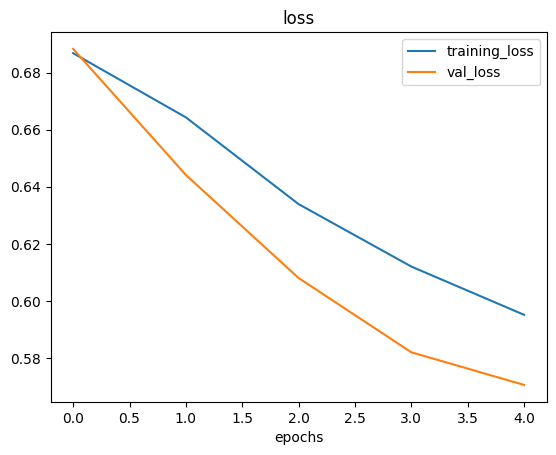

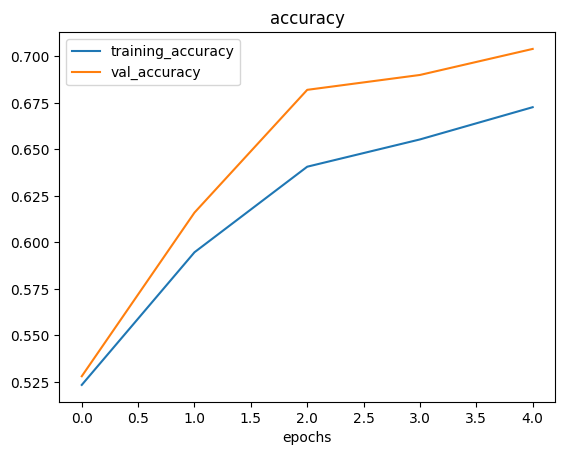

In [81]:
# Let's plot training curves
plot_loss_curves(history_6)

 >Let's shuffle our augmented training data ant train another model (the same as before) on it and see what happens

In [83]:
# Create our shuffled train and test dataset:
from tensorflow.keras.preprocessing import image_dataset_from_directory
 
train_data_shuffled = image_dataset_from_directory(directory=train_dir,
                                          label_mode="binary",
                                          batch_size=32,
                                          image_size=(224, 224),
                                          seed=42, 
                                          shuffle=True)
 
test_data = image_dataset_from_directory(directory=test_dir,
                                         label_mode="binary",
                                         batch_size=32,
                                         image_size=(224, 224),
                                         seed=42)

Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [85]:
# Create the model (same as model_5 and model_6)
# Создаем слой аугментации
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),  # Случайное отражение по горизонтали
    layers.RandomRotation(0.2),       # Поворот на ±20%
    layers.RandomZoom(0.2),           # Случайное увеличение/уменьшение
    layers.RandomContrast(0.1),       # Изменение контраста
    layers.RandomWidth(0.2),          # Случайное изменение ширины
    layers.RandomHeight(0.3),         # Случайное изменение высоты
], name="data_augmentation")

# Модель с аугментацией
model_7 = Sequential([
    Input(shape=(224, 224, 3)),
    data_augmentation,                # Аугментация
    Rescaling(scale=1/255.),           # Нормализация [0, 255] → [0, 1]
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    GlobalAveragePooling2D(),         # Используем GlobalAveragePooling2D вместо Flatten
    Dense(1, activation='sigmoid')
])

# Compile the model
model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_7 = model_7.fit(train_data_shuffled,
                        epochs=5,
                        validation_data=test_data)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.5109 - loss: 0.6886 - val_accuracy: 0.6340 - val_loss: 0.6692
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.5876 - loss: 0.6677 - val_accuracy: 0.5700 - val_loss: 0.6803
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - accuracy: 0.6527 - loss: 0.6334 - val_accuracy: 0.6860 - val_loss: 0.5813
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.6907 - loss: 0.5773 - val_accuracy: 0.7280 - val_loss: 0.5509
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.6942 - loss: 0.5670 - val_accuracy: 0.7300 - val_loss: 0.5377


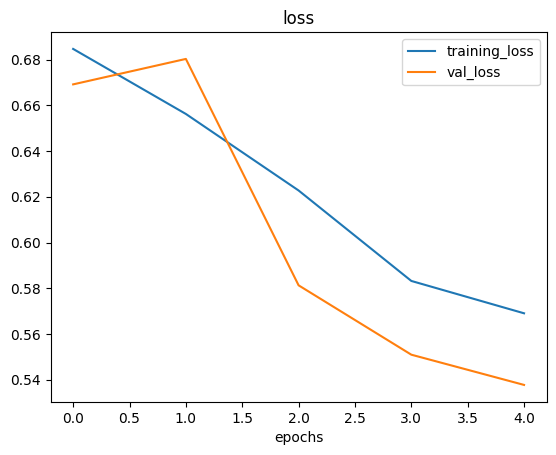

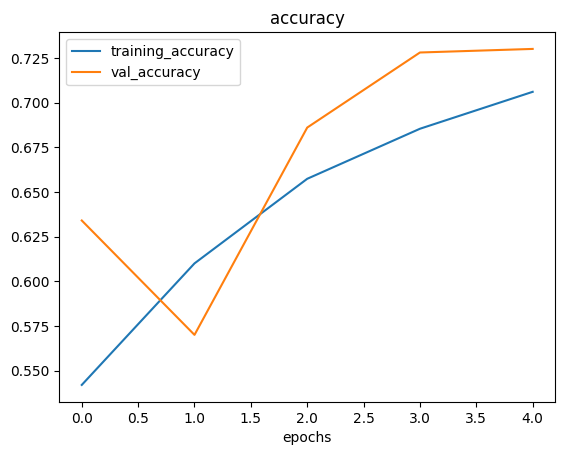

In [86]:
# Plot loss curves
plot_loss_curves(history_7)

In [87]:
model_6.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7023 - loss: 0.5736 


[0.5705691576004028, 0.7039999961853027]

In [88]:
model_7.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7622 - loss: 0.5163


[0.5377228856086731, 0.7300000190734863]